# Example: 2015-2020 abundance predictions for Tucson, Arizona

In this example we'll use the LSTM model to generate abundance predictions for 2015-2020 in Tucson, Arizona.

We start by loading necessary packages:

In [2]:
import tensorflow as tf
import os, json, joblib
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append("./utils")
sys.path.append("./models")
from generate_predictions import *
import pdb

#Packages to plot
from datetime import datetime, timedelta
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot


## Loading config, model, data, and scaling factor files

- Change **config_file, model_file, data_file** file paths to use different models/input data.
- **data_file** needs specific form:
    - Run the cell below for DataFrame format (2 options)
        - Option 1 Columns: 'Location', 'Year', 'Month', 'Day', 'Max_Temp', 'Min_Temp', 'Precip', 'Humidity'
        - Option 2 Columns: 'Location', 'Year', 'Month', 'Day', 'Max_Temp', 'Min_Temp', 'Precip', 'Humidity', 'MoLS'
    - In this example we assume we do not have access to MoLS data
- The **data_scaler.gz** file contains the MinMaxScaler used during the training process, and should be used to preprocess all inputs.
    - Do **not** change the scaling factors unless the model is retrained on new input data 


In [3]:
## Load config, model, data, scaling factors

config_file="./models/configs/lstm_config.json"
scaler_file="./data/data_scaler.gz"

#open config file
with open(config_file) as fp:
    config=json.load(fp)
data_shape=config["data"]["data_shape"]
model_file=config["files"]["model"]
data_file=config["files"]["testing"]

#load model
if os.path.exists(model_file):
    model = tf.keras.models.load_model(model_file,custom_objects={"r2_keras":r2_keras})
    print('MODEL LOADED')
    print(model.summary())

#load data scaler
scaler=joblib.load(scaler_file)

#load data
data=pd.read_pickle(data_file)
#Here we're only interested in Tucson,Arizona from 2015-2020.
data=data[data.Location=='Tucson,Arizona']
data=data[data.Year>2014]
data=data.reset_index(drop=True)



MODEL LOADED
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 90, 4)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 88, 64)            832       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 86, 64)            12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 64)            256       
_________________________________________________________________
lstm (LSTM)                  (None, 86, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)          

## Format input data and forecast abundance predictions

Use function from **./utils/generate_predictions.py** to format data correctly and make abundance forecasts

In [6]:
## Assume we don't have access to MoLS data
data=data.iloc[:,0:-1]

## Generate abundance forecast
results=gen_preds(model, data, data_shape, scaler, fit_scaler=False)

## Save results in a CSV file

In [4]:
if np.array_equal(results[:,-2],np.zeros(len(results))):
    results=np.delete(results, -2, 1)
    pd.DataFrame(results, columns=["Location","Year","Month","Day","Predicted Abundance"]).to_csv("Tucson_AZ_2015_2020_forecast.csv",index=False)
else:
    pd.DataFrame(results, columns=["Location","Year","Month","Day","MoLS Abundance","Predicted Abundance"]).to_csv("Tucson_AZ_2015_2020_forecast.csv",index=False)

## Plot results using **Plotly**

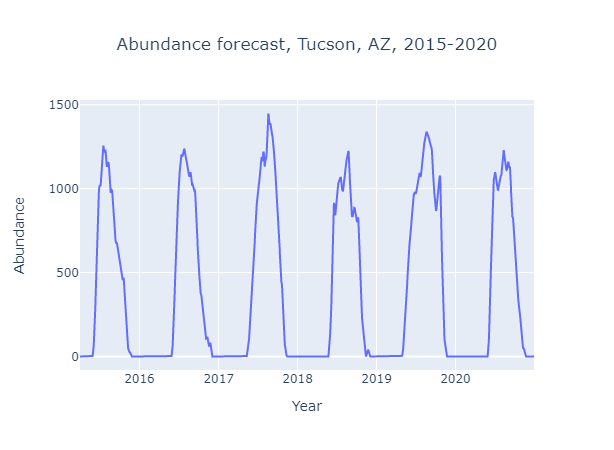

In [7]:
#set x-axis to be datetimes
x_data=np.arange(datetime(int(results[0,1]),int(results[0,2]),int(results[0,3])), 
                 datetime(int(results[-1,1]), int(results[-1,2]), int(results[-1,3])), 
                 timedelta(days=1)).astype(datetime)
trace = [go.Scatter(x=x_data,y=results[:,-1])]
layout = go.Layout(title="Abundance forecast, Tucson, AZ, 2015-2020", title_x=0.5, xaxis=dict(title="Year"),yaxis=dict(title="Abundance"))
fig=go.Figure(layout=layout, data=trace)
iplot(fig,filename='Tucson_AZ_2015_2020_forecast')